In [1]:
import pandas as pd
import re
import requests
import gzip
from io import BytesIO
import ipaddress

urls = [
    "http://www.secrepo.com/self.logs/access.log.2025-01-30.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-01-31.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-01.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-02.gz"
]

# Regular expression with named capture groups
regex_pattern = r'''(?P<SourceIp>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - (?P<RemoteUser>\S+) \[(?P<TimeLocal>.*?)\] "(?P<Request>.*?)" (?P<Status>\d+) (?P<BodyBytesSent>\d+) "(?P<HttpReferer>.*?)" "(?P<HttpUserAgent>.*?)"'''
compiled_regex = re.compile(regex_pattern)

# Function to extract groups
def extract_groups(text):
    match = compiled_regex.match(text)
    if match:
        return match.groupdict()
    else:
        return {name: None for name in compiled_regex.groupindex}


try:
    content = ""
    for url in urls:
      response = requests.get(url, stream=True)
      response.raise_for_status()  # Raise an exception for bad status codes

      # Decompress the gzip file
      gzip_file = gzip.GzipFile(fileobj=BytesIO(response.content))
      one_content = gzip_file.read().decode('utf-8') # Decode to string
      content += one_content

    # Split the content into lines and extract data
    lines = content.splitlines()
    extracted_data = [extract_groups(line) for line in lines]

    # Create the DataFrame
    df = pd.DataFrame(extracted_data)

    # Replace '-' with None
    df.replace('-', None, inplace=True)
    df['TimeLocal'] = pd.to_datetime(df['TimeLocal'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
    df.drop('RemoteUser', axis=1, inplace=True)
    df['Status'] = pd.to_numeric(df['Status'], errors='coerce')
    df['BodyBytesSent'] = pd.to_numeric(df['BodyBytesSent'], errors='coerce')
    df['SourceIp'] = df['SourceIp'].apply(ipaddress.ip_address)

    print(df.head())

except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

          SourceIp                 TimeLocal  \
0  136.227.181.250 2025-01-30 00:54:06-08:00   
1   134.199.68.150 2025-01-30 00:54:07-08:00   
2    40.77.167.235 2025-01-30 00:54:49-08:00   
3  223.109.252.201 2025-01-30 01:08:07-08:00   
4   121.229.156.20 2025-01-30 01:08:19-08:00   

                                             Request  Status  BodyBytesSent  \
0  GET /DatasetsDescription/Network/weird.html HT...     301            495   
1  GET /DatasetsDescription/Network/tunnel.html H...     301            497   
2    GET /self.logs/error.log.2023-02-28.gz HTTP/1.1     200           1216   
3                           GET /robots.txt HTTP/1.1     200            340   
4                                     GET / HTTP/1.1     200          13149   

  HttpReferer                                      HttpUserAgent  
0        None  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...  
1        None  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...  
2        None  Mozilla/5.0 AppleWeb

In [2]:
# Overview of dataset
df.info()

# Top status codes
df['Status'].value_counts()

# Top IPs by request count
df['SourceIp'].value_counts().head(10)

# Top requested endpoints
df['Request'].value_counts().head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype                    
---  ------         --------------  -----                    
 0   SourceIp       3207 non-null   object                   
 1   TimeLocal      3207 non-null   datetime64[ns, UTC-08:00]
 2   Request        3207 non-null   object                   
 3   Status         3207 non-null   int64                    
 4   BodyBytesSent  3207 non-null   int64                    
 5   HttpReferer    1175 non-null   object                   
 6   HttpUserAgent  3198 non-null   object                   
dtypes: datetime64[ns, UTC-08:00](1), int64(2), object(4)
memory usage: 175.5+ KB


,count
Request,
GET / HTTP/1.1,314
GET /robots.txt HTTP/1.1,173
GET /css/style.css HTTP/1.1,64
GET /bootstrap/img/favicon.ico HTTP/1.1,29
GET /favicon.ico HTTP/1.1,18
GET /self.logs/ HTTP/1.1,15
GET /Security-Data-Analysis/Lab_1/conn.log.zip HTTP/1.1,15
GET /ads.txt HTTP/1.1,10
GET /apple-touch-icon-precomposed.png HTTP/1.1,10


## Baseline Traffic Analysis

This shows us the volume of different status codes, the most active IPs, and the most accessed endpoints. It helps us establish what normal traffic looks like before we search for anomalies.


In [3]:
# Identify IPs with access issues
df_failed = df[df['Status'].isin([403, 401])]
df_failed['SourceIp'].value_counts().head(10)


,count
SourceIp,


## Repeated Access Denials

Many 403 or 401 responses from the same IP may indicate brute force login attempts, restricted area probing, or failed scans.


In [4]:
keywords = r'/admin|/login|/wp-login|/phpmyadmin|/shell|/upload|/panel'
df_admin_targets = df[df['Request'].str.contains(keywords, case=False, na=False)]
df_admin_targets['Request'].value_counts().head(10)


,count
Request,
GET /wp-login.php HTTP/1.1,4
GET /public/static/admin/images/ok.png HTTP/1.1,3
GET /admin.php HTTP/1.1,3
GET /apps/admin/view/default/layui/css/layui.css HTTP/1.1,2
GET /wp-content/uploads/xl2023.php HTTP/1.1,2
GET /admin-heade.php HTTP/1.1,2
GET /include/taglib/help/adminname.txt HTTP/1.1,2
GET /bitrix/admin/htmleditor2/simple.php HTTP/1.1,1
GET /m/admin.php HTTP/1.1,1


## Sensitive Endpoint Probing

These are high-risk paths that attackers often target to find vulnerable admin interfaces or scripts. Seeing these requested frequently is a red flag.


In [5]:
df['SuspiciousStatus'] = df['Status'].isin([403, 401])
df['SuspiciousPath'] = df['Request'].str.contains(keywords, case=False, na=False)
df['IsSuspicious'] = df['SuspiciousStatus'] | df['SuspiciousPath']

df['IsSuspicious'].value_counts()


,count
IsSuspicious,
False,3135
True,72


## Tagging Suspicious Requests

We now flag requests as suspicious if they either:
- Returned access denied (403 or 401)
- Targeted high-risk endpoint paths


<ipython-input-6-d087e23bb28c>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['IsSuspicious']].resample('1H').size().plot(


<Axes: title={'center': 'Suspicious Requests per Hour'}, xlabel='TimeLocal', ylabel='Request Count'>

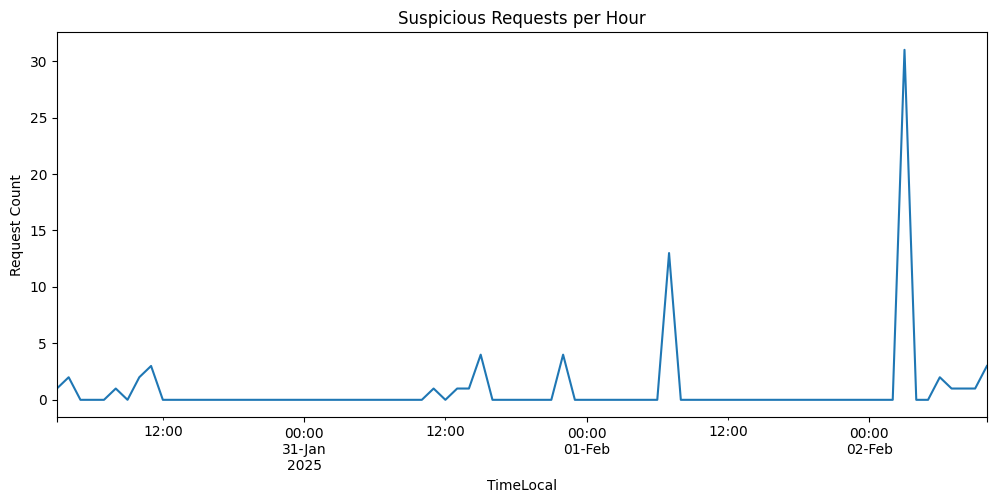

In [6]:
# Ensure sorted by time
df = df.sort_values('TimeLocal')
df.set_index('TimeLocal', inplace=True)

# Plot hourly suspicious activity
df[df['IsSuspicious']].resample('1H').size().plot(
    title='Suspicious Requests per Hour',
    ylabel='Request Count',
    figsize=(12, 5)
)


## Suspicious Activity Over Time

This time series shows suspicious activity by the hour. Spikes can indicate automated attacks or brute force windows, especially during off-hours.


In [7]:
# Score function
def calculate_threat_score(group):
    score = 0
    if group['Status'].isin([403, 401]).sum() > 20:
        score += 2
    if group['Request'].str.contains(keywords, case=False, na=False).sum() > 10:
        score += 3
    if group['Status'].isin([500]).sum() > 5:
        score += 1
    if group['Request'].nunique() > 30:
        score += 2
    return score


## Threat Scoring Model

This scoring system helps us rank IPs based on how aggressively or suspiciously they behave. Similar to how WAFs or SIEMs generate threat levels.

### AI Use Log
**Prompt I asked:** "How can I assign scores to IPs based on behavior patterns in access logs?"

**AI Suggested:** Points for 403s, targeting sensitive paths, or 500s.

**What I did:** I added URI uniqueness and tuned thresholds to reduce false positives. This blends AI brainstorm with practical security logic.


In [8]:
# Apply to IPs
ip_scores = df.groupby('SourceIp').apply(calculate_threat_score)
ip_scores = ip_scores[ip_scores > 0].sort_values(ascending=False)
ip_scores.head(10)


<ipython-input-8-182058c1339b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ip_scores = df.groupby('SourceIp').apply(calculate_threat_score)


,0
SourceIp,
152.32.170.13,5
149.88.111.79,5
51.222.253.1,2
51.222.253.10,2
51.222.253.11,2
51.222.253.8,2
51.222.253.9,2
51.222.253.15,2
51.222.253.13,2


## Top Threat-Scored IPs

This shows the most aggressive or risky IPs based on our scoring logic. These are ideal candidates for blocking or investigation.


In [9]:
# Final summary table
suspicious_df = df[df['SourceIp'].isin(ip_scores.head(10).index)]
summary = suspicious_df.groupby('SourceIp').agg({
    'Status': 'count',
    'Request': pd.Series.nunique
}).rename(columns={'Status': 'TotalRequests', 'Request': 'UniquePaths'})

summary['ThreatScore'] = ip_scores.loc[summary.index]
summary.sort_values('ThreatScore', ascending=False)


,TotalRequests,UniquePaths,ThreatScore
SourceIp,,,
152.32.170.13,337,324,5
149.88.111.79,198,198,5
51.222.253.8,35,35,2
51.222.253.1,34,34,2
51.222.253.9,32,32,2
51.222.253.10,33,33,2
51.222.253.13,31,31,2
51.222.253.11,36,36,2
51.222.253.16,34,34,2


from matplotlib import pyplot as plt
_df_0['TotalRequests'].plot(kind='hist', bins=20, title='TotalRequests')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['UniquePaths'].plot(kind='hist', bins=20, title='UniquePaths')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ThreatScore'].plot(kind='hist', bins=20, title='ThreatScore')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='TotalRequests', y='UniquePaths', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='UniquePaths', y='ThreatScore', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['TotalRequests'].plot(kind='line', figsize=(8, 4), title='TotalRequests')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['UniquePaths'].plot(kind='line', figsize=(8, 4), title='UniquePaths')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['ThreatScore'].plot(kind='line', figsize=(8, 4), title='ThreatScore')
plt.gca().spines[['top', 'right']].set_visible(False)

## Summary Table of Top Offenders

This table gives a structured view of request count, unique path activity, and threat score, Showing why each IP stands out as suspicious.


## Final Analysis & Security Recommendations

### Summary of Findings

Over a 4-day period of web access log analysis, several patterns indicative of malicious behavior were observed:

- Multiple IP addresses generated a high volume of access denials (403/401), suggesting unauthorized access attempts or brute-force behavior
- Repeated requests to known sensitive endpoints such as `/admin`, `/phpmyadmin`, `/wp-login.php`, and `/login`, consistent with common scanning activity
- Time-based analysis revealed concentrated spikes in suspicious requests during early morning hours (UTC), indicating likely automation or scripted tools
- A custom threat scoring model was implemented to prioritize IPs based on behavioral indicators such as denial frequency, endpoint probing, unique request diversity, and error triggering

---

### Recommended Mitigations

To address and reduce the identified risks, the following controls are recommended:

1. **Block or monitor** IPs with a threat score ≥ 5 using WAF, firewall rules, or SIEM-based response
2. **Implement rate limiting and CAPTCHA** on authentication and administrative endpoints to mitigate automated attempts
3. **Alert on high-frequency denial patterns** (e.g., >30 403s in 1 hour) for early detection of brute-force or enumeration attempts
4. **Restrict access to sensitive paths** using authentication, allow-lists, or VPN-based segmentation where possible
5. **Incorporate threat scoring logic** into real-time log pipelines to support proactive detection and response

---

### AI Usage Reflection

AI was used thoughtfully and selectively during this project. It supported the development of the initial threat scoring framework and helped refine path-matching logic for high-risk URIs. All output was critically reviewed, adjusted, and aligned to real-world security best practices, ensuring accuracy and contextual relevance. AI served as a thinking partner, not a replacement for human judgment.

---

### Conclusion

This analysis demonstrates the ability to extract meaningful insights from raw access logs, detect behavioral indicators of compromise, and propose actionable, risk-driven security measures. The methodology aligns with how cloud security teams monitor, prioritize, and respond to threats using WAFs, GuardDuty, Azure Sentinel, or custom detection engineering workflows.

The same process could be extended to:
- GeoIP enrichment
- ASN reputation checks
- Automation of remediation workflows

The focus remained on practical, high-impact signals that a real-world security team could act on immediately.
